<h1> Youtube Comments Sentiment Analysis using NLP

# Introduction  
Sentiment analysis is a crucial task in Natural Language Processing (NLP) that involves determining the sentiment behind a given text. This project explores sentiment classification using deep learning models, specifically GRU and LSTM, to analyze text data. Various preprocessing techniques, data augmentation methods, and hyperparameter tuning strategies were applied to improve model accuracy. By leveraging TensorFlow and Keras, we aimed to build an optimized model capable of classifying sentiment into three categories.  

Necessary Imports

In [208]:
import pandas as pd
import langid  
from deep_translator import GoogleTranslator
from tqdm import tqdm  
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import LSTM
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Reading the dataset using the variable 'df'

In [ ]:
df=pd.read_csv('YoutubeCommentsDataSet.csv')
print(df.sample(10).to_string(index=False))

Checking summary statistics and dataset information.

In [ ]:
display(df.describe())
display(df.info)

Checking for null values

In [ ]:
print(df.isnull().sum())

Dropping the whole records where null values were found

In [ ]:
df = df.dropna()
print(df.isnull().sum())

Identifying Non-English Comments  
Detecting non-English comments to separate them for later translation.


In [ ]:
def is_english(text):
    lang, _ = langid.classify(text)
    return lang == 'en'

df["is_english"] = df["Comment"].apply(is_english)

df_english = df[df["is_english"]]
df_non_english = df[~df["is_english"]]

print(f"Total non-English comments: {len(df_non_english)}")  
print(f"Total English comments: {len(df_english)}")
df.drop(columns=["is_english"], inplace=True)  

Translating Non-English Comments  
Using Google Translator to convert non-English comments into English, then merging them back into the dataset.


In [ ]:
translator = GoogleTranslator(source="auto", target="en")

def translate_to_english(text):
    try:
        return translator.translate(text)
    except Exception:
        return text  

tqdm.pandas(desc="Translating")
df_non_english["Comment"] = df_non_english["Comment"].progress_apply(translate_to_english)


df_combined = pd.concat([df_english, df_non_english], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(" Translation complete! Here's a preview:")
print(df_combined.head())

The conversion process took around 30 minutes. So we then save this to a new csv file to avoid re-runs.

In [ ]:
df_combined.to_csv("Translated.csv")

Now reading the dataset from the newly created csv file.

In [216]:
df=pd.read_csv('Translated.csv')
print(df.head())

   Unnamed: 0                                            Comment Sentiment  \
0           0  i have been trying to solve a rubik’s cube for...  positive   
1           1  thank you for a lovely video i must admit that...  positive   
2           2              ahah you are lucky soon the splatfest   neutral   
3           3  omg as an international student i was kinda ho...  positive   
4           4  so clever of joes puppetmaster to say that sam...  negative   

   is_english  
0        True  
1        True  
2       False  
3        True  
4        True  


Dropping the unwanted column created (old_index and is_english).

In [217]:
df = df.drop(columns=['Unnamed: 0', 'is_english'])

df = df.reset_index(drop=True)

print(df.head())

                                             Comment Sentiment
0  i have been trying to solve a rubik’s cube for...  positive
1  thank you for a lovely video i must admit that...  positive
2              ahah you are lucky soon the splatfest   neutral
3  omg as an international student i was kinda ho...  positive
4  so clever of joes puppetmaster to say that sam...  negative


In [218]:
df=df.dropna(axis=0)
print(df.sample(10))

                                                 Comment Sentiment
18083  cute animals  love your videos super like as a...  positive
12556  plague requiem high on life and moon scars are...  positive
6724   915 this father actually died from the fall tr...  negative
3050                                            awesome   positive
13221  if one guy posting memes in a group chat is th...   neutral
4139   I work with Vescovi any day I will ask from el...   neutral
10025  its never about who bring magnus or hikaru at ...  positive
15810  taking the sat on saturday good luck to everyo...  positive
10218  loving the series cc does anyone know any refe...  positive
1392   this actually worked really well for me the fi...  positive


Text Cleaning: Removing Special Characters  
Cleaning comments by
1. Converting to lowercase
2. Expanding contractions
3. Removing any URLs
4. Removing any user tags '@'
5. Keeping only alphanumerics and spaces
6. Removing extra spaces


In [219]:
def clean_text(text):
    text = text.lower()  
    text = contractions.fix(text) 
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r"@\w+", "", text)  
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text  

df["Comment"] = df["Comment"].apply(clean_text)

print(df.head())

                                             Comment Sentiment
0  i have been trying to solve a rubiks cube for ...  positive
1  thank you for a lovely video i must admit that...  positive
2              ahah you are lucky soon the splatfest   neutral
3  omg as an international student i was kind of ...  positive
4  so clever of joes puppetmaster to say that sam...  negative


Text Preprocessing: Stopword Removal & Lemmatization  
Tokenizing comments, removing stopwords, and applying lemmatization to normalize text.


In [220]:
nltk.download(['stopwords', 'wordnet', 'punkt'])

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.discard('not')  

def preprocess_text(text):
    words = text.split()  
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

df['Comment'] = df['Comment'].apply(preprocess_text)

print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kesav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kesav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                             Comment Sentiment
0  trying solve rubiks cube year video made confi...  positive
1  thank lovely video must admit said really help...  positive
2                          ahah lucky soon splatfest   neutral
3  omg international student kind hopeless exam f...  positive
4  clever joes puppetmaster say guy said not unde...  negative


In [221]:
print(df.sample(10))

                                                 Comment Sentiment
17849  great platform auto crypto arbitrage think spe...  positive
14606  must fed praise beauty nature not mean proud b...   neutral
14988  pretty good summary disagree statement not sci...   neutral
7847   sorry way said poor took not expecting cackle ...  negative
3198   please make video pre college ec c highschoole...   neutral
13621  hi everyone pointed map 936 incorrectly show t...  negative
10801                    get 57 365 data science program   neutral
15798      ill upgrade finally put usbc next year iphone  positive
10616  discovered channel series going watching older...  positive
8879                   keep fight m cheney country party  positive


Encoding Sentiment Labels  
Converting sentiment categories into numerical values for model training.  
- **Negative → 0**  
- **Neutral → 1**  
- **Positive → 2**  


In [222]:
df['Sentiment'] = df['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

print(df.head())

                                             Comment  Sentiment
0  trying solve rubiks cube year video made confi...          2
1  thank lovely video must admit said really help...          2
2                          ahah lucky soon splatfest          1
3  omg international student kind hopeless exam f...          2
4  clever joes puppetmaster say guy said not unde...          0


Tokenization: Converting Text to Sequences  
Using Keras Tokenizer to convert comments into numerical sequences while keeping the top 5000 most frequent words.  
Out-of-vocabulary (OOV) words are replaced with `<OOV>`.  


In [223]:
vocab_size = 5000  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  
tokenizer.fit_on_texts(df['Comment'])

X_tokens = tokenizer.texts_to_sequences(df['Comment'])


print(f"Total unique words: {len(tokenizer.word_index)}")  
print(f"Words actually used (excluding OOV): {len(tokenizer.index_word)}")  
print(f"Words kept (max vocab size): {vocab_size}")  
print(f"Example tokenized comment: {X_tokens[0] if X_tokens else 'No data'}")

Total unique words: 29160
Words actually used (excluding OOV): 29160
Words kept (max vocab size): 5000
Example tokenized comment: [174, 439, 826, 114, 16, 3, 50, 840, 158, 826, 114, 13, 81, 3]


Analyzing Word Frequencies  
Sorting words by frequency to identify those excluded from the top 5000 vocabulary limit.


In [224]:
word_counts = tokenizer.word_counts  
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)  


if len(sorted_word_counts) > vocab_size:
    excluded_words = sorted_word_counts[vocab_size:]  
else:
    excluded_words = []  

df_excluded = pd.DataFrame(excluded_words, columns=['Word', 'Frequency'])

if not df_excluded.empty:
    print(" Top 20 words excluded from vocabulary:")
    print(df_excluded.head(20))
else:
    print(" No words were excluded, as total unique words are within vocab_size.")


 Top 20 words excluded from vocabulary:
             Word  Frequency
0      resistance          7
1          seetoh          7
2         poverty          7
3            2012          7
4           canon          7
5         glucose          7
6           venom          7
7           stake          7
8          roller          7
9           nurse          7
10        abandon          7
11            sio          7
12        sinking          7
13      authority          7
14         gladly          7
15          drill          7
16         injury          7
17  communicating          7
18       employed          7
19        axolotl          7


Analyzing Comment Lengths  
Checking the distribution of comment lengths to determine an optimal padding length.  
- **Max Length** → Longest comment  
- **Average Length** → Mean comment length  
- **90th Percentile** → Covers 90% of comments  


In [225]:
comment_lengths = [len(seq) for seq in X_tokens]

print(f" Min comment length: {np.min(comment_lengths)}")
print(f" Max comment length: {np.max(comment_lengths)}")
print(f" Median comment length: {np.median(comment_lengths)}")
print(f" Average comment length: {np.mean(comment_lengths):.2f}")
print(f" 90th percentile length: {np.percentile(comment_lengths, 90)}")


hist, bins = np.histogram(comment_lengths, bins=10)
print("\n Length distribution (Histogram):")
for i in range(len(bins) - 1):
    print(f" - {int(bins[i])} to {int(bins[i+1])}: {hist[i]} comments")


 Min comment length: 0
 Max comment length: 1288
 Median comment length: 11.0
 Average comment length: 17.73
 90th percentile length: 35.0

 Length distribution (Histogram):
 - 0 to 128: 18239 comments
 - 128 to 257: 94 comments
 - 257 to 386: 16 comments
 - 386 to 515: 9 comments
 - 515 to 644: 2 comments
 - 644 to 772: 1 comments
 - 772 to 901: 1 comments
 - 901 to 1030: 0 comments
 - 1030 to 1159: 0 comments
 - 1159 to 1288: 1 comments


Padding Sequences for Uniform Length  
Ensuring all comments have the same length by padding or truncating them to **35 tokens** based on length analysis.  
- **Padding:** Adds zeros at the end of shorter sequences.  
- **Truncating:** Cuts longer sequences at the end.  


In [226]:
maxlen = 35  
X_padded = pad_sequences(X_tokens, maxlen=maxlen, padding='post', truncating='post')

print(f" Padded sequences shape: {X_padded.shape}") 
print(f" Example padded sequence: {X_padded[0]}")


 Padded sequences shape: (18363, 35)
 Example padded sequence: [174 439 826 114  16   3  50 840 158 826 114  13  81   3   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Checking the dataset after all the preprocessing

In [227]:
print(pd.DataFrame(X_padded).head(10).to_string())

     0     1     2    3     4    5     6     7    8     9     10    11    12    13   14    15  16    17   18    19  20  21  22   23  24  25    26    27   28  29   30   31   32    33    34
0   174   439   826  114    16    3    50   840  158   826   114    13    81     3    0     0   0     0    0     0   0   0   0    0   0   0     0     0    0   0    0    0    0     0     0
1    13  1368     3  311  1830  102     8   278    1    23  3767   661    13   129    4     3  15  3768    4  1028   1   7   0    0   0   0     0     0    0   0    0    0    0     0     0
2     1  1153   390    1     0    0     0     0    0     0     0     0     0     0    0     0   0     0    0     0   0   0   0    0   0   0     0     0    0   0    0    0    0     0     0
3   841  1627   130  126     1  652   192    71    1   621     3  2075    47    64    0     0   0     0    0     0   0   0   0    0   0   0     0     0    0   0    0    0    0     0     0
4  3143     1     1   55    54  102     2     1    1   801  

Splitting the dataset into training, testing and validation datasets.

In [228]:
X = X_padded  
y = df['Sentiment'] 

y = to_categorical(y, num_classes=3)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Building the GRU model

In [229]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
    
model.compile(optimizer=Adam(learning_rate=1e-4),  
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

Training the model

In [230]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4775 - loss: 1.0647 - val_accuracy: 0.6171 - val_loss: 0.9637
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6315 - loss: 0.9355 - val_accuracy: 0.6236 - val_loss: 0.9145
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6341 - loss: 0.8929 - val_accuracy: 0.6264 - val_loss: 0.9077
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6427 - loss: 0.8669 - val_accuracy: 0.6253 - val_loss: 0.9689
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6610 - loss: 0.8274 - val_accuracy: 0.6275 - val_loss: 0.8705
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7085 - loss: 0.6591 - val_accuracy: 0.6890 - val_loss: 0.7152
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7554 - loss: 0.5683 - val_accuracy: 0.6939 - val_loss: 0.7343
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7827 - loss: 0.5222 - val_accu

Evaluating the model

In [231]:
y_pred = model.predict(X_test)

y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Test Accuracy: 0.6973

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.25      0.36       252
           1       0.47      0.51      0.49       458
           2       0.79      0.88      0.83      1127

    accuracy                           0.70      1837
   macro avg       0.64      0.54      0.56      1837
weighted avg       0.69      0.70      0.68      1837



 Model Hyperparameter Tuning Setup

In [232]:
def build_model(hp):
    model = Sequential()
    

    model.add(Embedding(
        input_dim=5000,
        output_dim=hp.Int('embedding_dim', min_value=50, max_value=200, step=50)
    ))
    

    model.add(GRU(
        hp.Int('gru_units_1', min_value=32, max_value=256, step=32),
        return_sequences=hp.Choice('gru_layer_2', [True, False])  
    ))
    

    if hp.Choice('gru_layer_2', [True, False]):
        model.add(GRU(hp.Int('gru_units_2', min_value=32, max_value=128, step=32)))
    
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    

    if hp.Boolean('batch_norm'):
        model.add(BatchNormalization())
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

 Hyperparameter tuning using Keras Tuner's Hyperband for `val_accuracy`.


In [233]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='sentiment_analysis'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Reloading Tuner from my_dir\sentiment_analysis\tuner0.json


Printing out the best hyperparameters

In [234]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hps.values)

# Best hyperparameters: {
    # 'embedding_dim': 50,
    # 'gru_units_1': 192,
    # 'gru_layer_2': 0,
    # 'gru_units_2': 96,
    # 'dropout_rate': 0.2,
    # 'dense_units': 256,
    # 'batch_norm': False,
    # 'learning_rate': 0.001494669481799156,
    # 'tuner/epochs': 4,
    # 'tuner/initial_epoch': 2,
    # 'tuner/bracket': 2,
    # 'tuner/round': 1,
    # 'tuner/trial_id': '0005'
    # }

Best hyperparameters: {'embedding_dim': 50, 'gru_units_1': 192, 'gru_layer_2': 0, 'gru_units_2': 96, 'dropout_rate': 0.2, 'dense_units': 256, 'batch_norm': False, 'learning_rate': 0.001494669481799156, 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0005'}


Building the best model 

In [235]:
best_model = Sequential()
best_model.add(Embedding(input_dim=5000, output_dim=50))  
best_model.add(GRU(192, return_sequences=False))  
best_model.add(Dropout(0.2))  
best_model.add(Dense(256, activation='relu'))  
best_model.add(Dense(3, activation='softmax')) 

best_model.compile(optimizer=Adam(learning_rate=0.001494669481799156),  
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Fitting it with the training and validation data

In [236]:
best_model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/4


460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6283 - loss: 0.9103 - val_accuracy: 0.6253 - val_loss: 0.8916
Epoch 2/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6563 - loss: 0.8233 - val_accuracy: 0.6792 - val_loss: 0.6998
Epoch 3/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7580 - loss: 0.5574 - val_accuracy: 0.7331 - val_loss: 0.6366
Epoch 4/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8264 - loss: 0.4408 - val_accuracy: 0.7113 - val_loss: 0.7262


Evaluating the model

In [237]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7206 - loss: 0.7179
Test Loss: 0.7429866194725037
Test Accuracy: 0.7147523164749146


Generating the classification report by predicting the test values

In [238]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.60      0.36      0.45       252
           1       0.52      0.49      0.50       458
           2       0.80      0.89      0.84      1127

    accuracy                           0.71      1837
   macro avg       0.64      0.58      0.60      1837
weighted avg       0.70      0.71      0.70      1837



Confusion Matrix  
Generates and visualizes the confusion matrix to evaluate model performance across sentiment classes.  

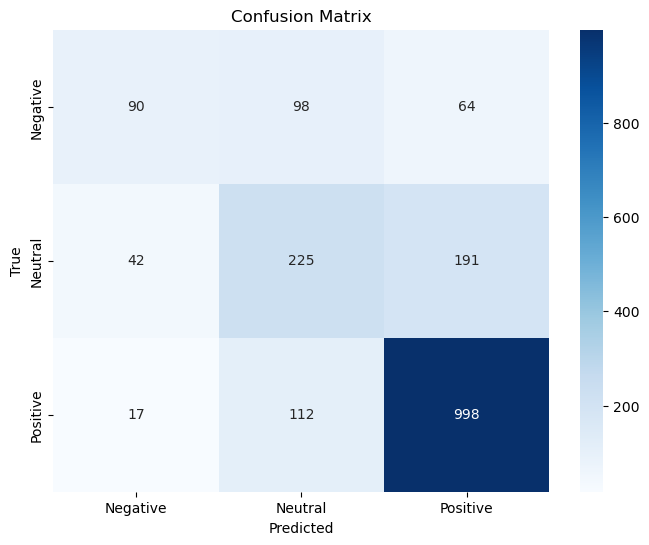

In [239]:
y_pred_labels = y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)


conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
class_labels = ['Negative', 'Neutral', 'Positive']


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Saving the model

In [240]:
best_model.save('sentiment_analysis_model.keras')

Building the Second Model (LSTM)

In [241]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100))  
model.add(LSTM(128, return_sequences=False))  
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))  
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

Training the model

In [242]:
model.fit(X_train, y_train, batch_size=32, epochs=10 ,validation_data=(X_val, y_val))

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6271 - loss: 0.8984 - val_accuracy: 0.7032 - val_loss: 0.6753
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7247 - loss: 0.6311 - val_accuracy: 0.7141 - val_loss: 0.6748
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7736 - loss: 0.5341 - val_accuracy: 0.7222 - val_loss: 0.7234
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8183 - loss: 0.4627 - val_accuracy: 0.7168 - val_loss: 0.7211
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8562 - loss: 0.3941 - val_accuracy: 0.7032 - val_loss: 0.7791
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8796 - loss: 0.3452 - val_accuracy: 0.6983 - val_loss: 0.8680
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8951 - loss: 0.3069 - val_accuracy: 0.7037 - val_loss: 0.8515
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9139 - loss: 0.2587 - val_accu

Evaluating the model

In [243]:
y_pred = model.predict(X_test)

y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test Accuracy: 0.7039

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.38      0.45       252
           1       0.50      0.47      0.48       458
           2       0.79      0.87      0.83      1127

    accuracy                           0.70      1837
   macro avg       0.62      0.57      0.59      1837
weighted avg       0.69      0.70      0.69      1837



Define LSTM model with hyperparameter tuning for embedding dimensions, LSTM units, dropout rate, dense units, and learning rate.


In [244]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=50, max_value=200, step=50)))
    model.add(LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=False))
    
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Initialize Hyperband tuner for LSTM model with validation accuracy as the objective.


In [ ]:
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='sentiment_analysis_lstm'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Reloading Tuner from my_dir\sentiment_analysis_lstm\tuner0.json


Printing the best values for each hyperparamaters

In [246]:
# print(best_hps.values)

# {
    # 'embedding_dim': 50,
    # 'lstm_units': 64,
    # dropout_rate': 0.2,
    # 'dense_units': 256,
    # 'learning_rate': 0.0018049869309856735,
    # 'tuner/epochs': 4,
    # 'tuner/initial_epoch': 0,
    # 'tuner/bracket': 1,
    # 'tuner/round': 0
    # }

Building the best model 

In [247]:
best_model = Sequential()
best_model.add(Embedding(input_dim=5000, output_dim=50))  
best_model.add(LSTM(64, return_sequences=False))  
best_model.add(Dropout(0.2))  
best_model.add(Dense(256, activation='relu'))  
best_model.add(Dense(3, activation='softmax'))  

best_model.compile(optimizer=Adam(learning_rate=0.0018049869309856735),  
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

Fitting it with the training and validation data

In [248]:
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6178 - loss: 0.8976 - val_accuracy: 0.6999 - val_loss: 0.7076
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7169 - loss: 0.6405 - val_accuracy: 0.7086 - val_loss: 0.6782
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7711 - loss: 0.5300 - val_accuracy: 0.6868 - val_loss: 0.7517
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8087 - loss: 0.4658 - val_accuracy: 0.7097 - val_loss: 0.7361
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8570 - loss: 0.3804 - val_accuracy: 0.7070 - val_loss: 0.8316
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8830 - loss: 0.3289 - val_accuracy: 0.7086 - val_loss: 0.9032
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9091 - loss: 0.2689 - val_accuracy: 0.7053 - val_loss: 0.9652
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9189 - loss: 0.2423 - val_accuracy: 0.

Generating the classification report after predicting the test values

In [249]:
y_pred = best_model.predict(X_test)

y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.7017

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.32      0.42       252
           1       0.50      0.47      0.48       458
           2       0.78      0.88      0.83      1127

    accuracy                           0.70      1837
   macro avg       0.63      0.56      0.58      1837
weighted avg       0.69      0.70      0.69      1837



Plotting the confusion matrix

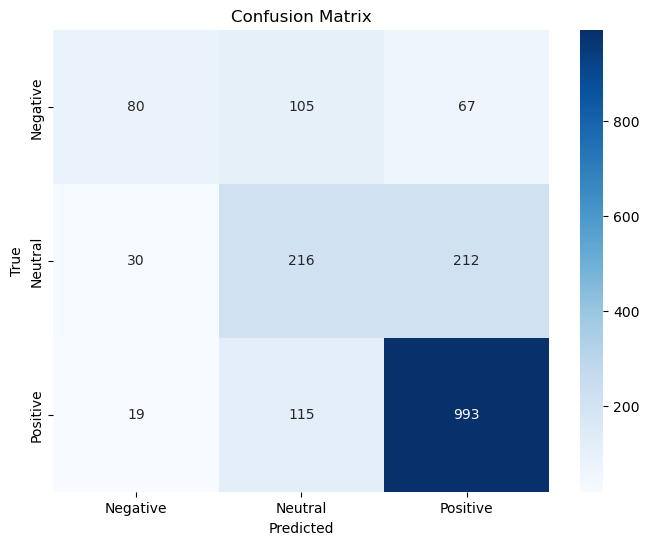

In [250]:
y_pred_labels = y_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)


conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
class_labels = ['Negative', 'Neutral', 'Positive']


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Saving the model

In [ ]:
best_model.save('sentiment_analysis_model_lstm.keras')

# Conclusion  
Through rigorous experimentation, we implemented and fine-tuned GRU and LSTM models for sentiment analysis. Despite extensive optimizations, the dataset posed challenges that limited accuracy improvements. Hyperparameter tuning helped refine model performance, but the results highlight the importance of high-quality, balanced datasets for better classification. This project demonstrates the potential and limitations of deep learning in sentiment analysis, providing valuable insights for future work in NLP.  
